# Training SVM

### To-do:
<ul>
    <li> Find and track optimal parameters for SVM </li>
    <li> Modify generate data function to include outside subject data w/ normalization </li>
    <li> Track accuracy report </li>
</ul>

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import scipy.io
import os

In [12]:
subjects

['AT', 'CC', 'CG', 'GD', 'JM', 'JR', 'JS', 'NL', 'RK', 'SC', 'TP', 'YY']

In [25]:
'''
Gets a list of subject IDs and file suffix, given a path to the data files

Note: subject ID must be only 2 characters for this to work, and all data files
must have same suffix
'''
def get_subjects(path):
    
    files = os.listdir(path)
    subjects = [f[:2] for f in files]
    suffix = files[0][2:]
    subjects.remove('ML')
    subjects.sort()
    
    return subjects, suffix

In [58]:
'''
Randomly selects half of the labels in the data to switch to the other class. 

y_data:   list of the label data
classes:  list of the two different classes of labels
'''
def scramble_labels(y_data, classes):
    
    for index in np.nditer(np.random.choice(len(y_data), size=len(y_data)//2, replace=False)):
        
        if y_data[index] == classes[0]:
            # print("%i: %s -> %s" % (index, y_data[index], classes[1]))
            y_data[index] = classes[1]
        else:
            # print("%i: %s -> %s" % (index, y_data[index], classes[0]))
            y_data[index] = classes[0]


In [9]:
'''
Gets individuals subject data.

path:          directory to data files
subject:       specific subject data to load
suffix:        ending to filename
roi:           0 for MT data, 1 for V1 data
conds:         which conditional dataset to extract
block_length:  standardized number of voxels per block
'''
def extract_subject_data(path, subject, suffix, roi, conds, block_length):
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
        
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            for block in range(len(mat[0][scan][0][cond][0])):

                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                
                # Filters for most active voxels in each block
                block_data.sort()
                block_data = block_data[-block_length:]
                
                x_data.append(block_data)
                y_data.append(mat[0][scan][1][cond][0])
                
    data = {'x': x_data, 'y': y_data}
    return data

In [ ]:
def get_optimal_params():

In [180]:
'''
Generates training and testing data.
'''
def generate_data(subjects, inner_test_subject, outer_test_subject, path, suffix, block_length, roi, conds):
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for subject in range(len(subjects)):
        
        if subject == outer_test_subject or subject == inner_test_subject:
            continue
        subject_data = extract_subject_data(path, subjects[subject], suffix, roi, conds, block_length)
        x_train.extend(subject_data['x'])
        y_train.extend(subject_data['y'])
    
    test_data = extract_subject_data(path, subjects[inner_test_subject], suffix, roi, conds, block_length)
    
    x_train_len = len(x_train)
    x_train.extend(test_data['x'])
    
    # MinMaxScaler scales each feature to values between 0 and 1 among all x data
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_normalized = scaler.fit_transform(x_train)
    x_train, x_test = x_normalized[:x_train_len], x_normalized[x_train_len:]

    y_test = test_data['y']
    y_train = np.stack(y_train, axis=0)
    
    return x_train, y_train, x_test, y_test

In [182]:
'''
Trains the classifier, uses nested cross-validation.

x_data:        formatted array of all subject voxel data
y_data:        formatted array of labels corresponding to the x_data
path:          path to data files
kernel_type:   type of kernel to run SVC 
               (options are 'linear', 'rbf', 'poly', 'sigmoid')
roi:           0 for V1, 1 for MT
conds:         which conditional dataset to extract
block_length:  standardized number of voxels per block
'''
def train(path, kernel_type, roi, conds, block_length):
    
    subjects, suffix = get_subjects(path)
    acc_report = pd.DataFrame(index=subjects, columns=subjects)
    
    for outer_subject in range(len(subjects)):
        
        # print("Currently on outer subject #%i." % (outer_subject))

        outer_data = extract_subject_data(path, subjects[outer_subject], suffix, roi, conds, block_length)
        outer_x_test, outer_y_test = np.array(outer_data['x']), np.array(outer_data['y'])

        for inner_subject in range(len(subjects)):

            if inner_subject == outer_subject:
                continue

            # print("Currently on inner subject #%i." % (inner_subject))    
            x_train, y_train, x_test, y_test = generate_data(subjects, inner_subject, outer_subject, path, suffix, block_length, roi, conds)
            scramble_labels(y_train, classes)    
                
            # train model
            # type of kernel will change
            svclassifier = SVC(kernel=kernel_type, gamma='auto', max_iter=-1)
            svclassifier.fit(x_train, y_train)
            
            # set aside testing subject for inner loop
            acc = svclassifier.score(x_train, y_train)
            
            index = subjects[outer_subject]
            col = subjects[inner_subject]
            acc_report.at[index, col] = acc

        # test outer subject
    
    return acc_report

## Training model for accuracy

For rbf kernel, should check grid points to find good values of C and gamma (necessary for performance) <br>
<a href="https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel"> sklearn.model_selection.GridSearchCV </a><br>

In [118]:
kernel_type = 'linear'
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624 

accs = train(path, kernel_type, roi, conds, block_length)

Currently on outer subject #0.

Currently on outer subject #1.

Currently on outer subject #2.

Currently on outer subject #3.

Currently on outer subject #4.

Currently on outer subject #5.

Currently on outer subject #6.

Currently on outer subject #7.

Currently on outer subject #8.

Currently on outer subject #9.

Currently on outer subject #10.

Currently on outer subject #11.



In [119]:
accs

,AT,CC,CG,GD,JM,JR,JS,NL,RK,SC,TP,YY
AT,NaN,0.601562,0.568182,0.551471,0.55303,0.628788,0.537879,0.609375,0.575758,0.53125,0.575758,0.578125
CC,0.554688,NaN,0.625,0.598485,0.554688,0.5625,0.585938,0.532258,0.5625,0.524194,0.554688,0.580645
CG,0.575758,0.546875,NaN,0.558824,0.606061,0.545455,0.606061,0.539062,0.575758,0.585938,0.537879,0.546875
GD,0.566176,0.575758,0.492647,NaN,0.580882,0.610294,0.566176,0.575758,0.551471,0.568182,0.551471,0.560606
JM,0.583333,0.546875,0.545455,0.617647,NaN,0.55303,0.568182,0.578125,0.55303,0.570312,0.560606,0.578125
JR,0.575758,0.5625,0.537879,0.595588,0.530303,NaN,0.545455,0.59375,0.621212,0.578125,0.55303,0.59375
JS,0.621212,0.515625,0.522727,0.566176,0.560606,0.590909,NaN,0.578125,0.55303,0.546875,0.537879,0.546875
NL,0.554688,0.612903,0.570312,0.598485,0.554688,0.59375,0.539062,NaN,0.59375,0.556452,0.65625,0.620968
RK,0.55303,0.617188,0.590909,0.522059,0.55303,0.55303,0.537879,0.554688,NaN,0.539062,0.583333,0.640625
SC,0.523438,0.620968,0.632812,0.590909,0.585938,0.59375,0.625,0.540323,0.601562,NaN,0.632812,0.596774


## Histograms of Different Kernel Accuracies

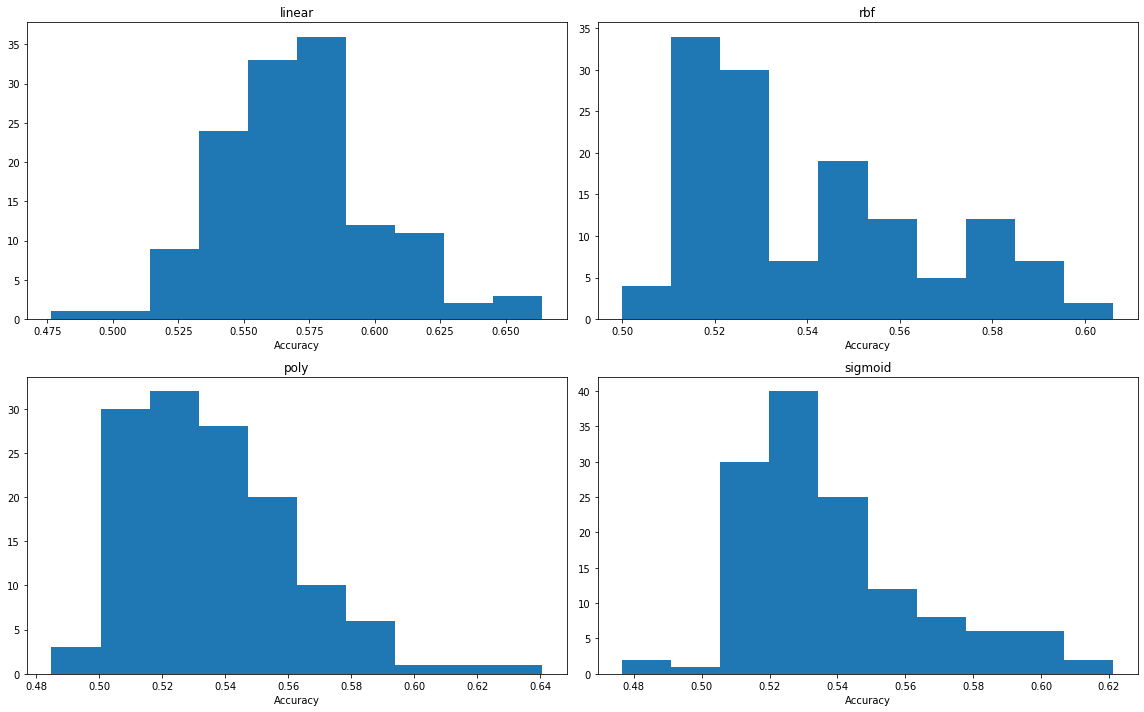

In [183]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624 

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
fig, axes = plt.subplots(2, 2, figsize=(16,10), squeeze=False)

kernel_accs = {}

for i, kernel in enumerate(kernels):
    
    accs = train(path, kernel, roi, conds, block_length)
    kernel_accs[kernel] = accs
    vals = []
    for column in accs:
        vals.extend(accs[column].tolist())
    vals = [x for x in vals if str(x) != 'nan']
    
    row = 0
    if i > 1:
        row = 1
    col = 0
    if i == 1 or i == 3:
        col = 1
    
    axes[row, col].hist(vals)
    axes[row, col].set_title(kernel)
    axes[row, col].set_xlabel('Accuracy')

fig.tight_layout()
plt.savefig('acc_comparison.png')
plt.show()

### Debugging

In [11]:
kernel_type = 'poly'
path = r'scans/output/PRE/'
suffix = "PRE_EVERY_TR_roi.mat"
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
subjects = get_subjects(path)
block_length = 624                 # minimum block length

inner_subject = 3
outer_subject = 0
x_train, y_train, x_test, y_test = generate_data(subjects, inner_subject, outer_subject, path, suffix, block_length, roi, conds)
svclassifier = SVC(kernel=kernel_type, gamma='auto', max_iter=-1)
svclassifier.fit(x_train, y_train)

svclassifier.score(x_test, y_test)


0.5

In [837]:
kernel_type = 'sigmoid'
path = r'scans/output/PRE/'
suffix = "PRE_EVERY_TR_roi.mat"
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
subjects = get_subjects(path)
block_length = 624                 # minimum block length

data = extract_subject_data(path, subjects[2], suffix, roi, conds, block_length)
#svclassifier = SVC(kernel=kernel_type, gamma='auto', max_iter=-1)
#svclassifier.fit(data['x'], data['y'])

In [734]:
test_data = extract_subject_data(path, subjects[1], suffix, roi, conds, block_length)
svclassifier.score(test_data['x'], test_data['y'])

0.625

In [53]:
classes = ['trained_ip', 'untrained_ip']

data = extract_subject_data(path, subjects[0], suffix, roi, conds, block_length)
scramble_labels(data['y'], classes)

0: trained_ip -> untrained_ip
5: trained_ip -> untrained_ip
6: untrained_ip -> trained_ip
8: trained_ip -> untrained_ip
7: untrained_ip -> trained_ip
1: trained_ip -> untrained_ip


### Accuracy Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))